# CONVOLUTIONAL NEURAL NETWORK TO CLASSIFY CATS AND DOGS

Importing the necessary packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import splitfolders
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F 


Specifying the necessary image transformations

In [4]:
def rescale(img, target_size):
    h, w = img.size
    scale = min(target_size/w, target_size/h)
    nw = int(w * scale)
    nh = int(h * scale)
    px = (target_size - nw)//2 if target_size > nw else 0
    py = (target_size - nh)//2 if target_size > nh else 0
    img = img.resize((nw, nh), Image.BILINEAR)
    new_img = Image.new('RGB', (target_size, target_size), (0, 0, 0))
    new_img.paste(img, (px, py))
    return new_img


In [5]:
train_transform = transforms.Compose(
    [transforms.Lambda(lambda img : rescale(img, 256)),
     transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(15),
     transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [6]:
transform = transforms.Compose(
    [transforms.Lambda(lambda img : rescale(img, 256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

Splitting the dataset into training, validation and testing dataset

In [7]:
input_folder = './PetImages'
output_folder = './PetImagesGrouped'
splitfolders.ratio(input_folder, output = output_folder, seed = 42, ratio = (.7, .1, .2))

Copying files: 24998 files [00:54, 457.36 files/s]


In [8]:
train_dataset = ImageFolder(root = './PetImagesGrouped/train', transform = train_transform)
val_dataset = ImageFolder(root = './PetImagesGrouped/val', transform = transform)
test_dataset = ImageFolder(root = './PetImagesGrouped/test', transform = transform)

Creating Train, Validation and Test DataLoaders

In [9]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

Defining the CNN Architecture

In [10]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv6 = nn.Conv2d(256, 512, 3, 1, 1)
        self.conv7 = nn.Conv2d(512, 1024, 3, 1, 1)
        self.conv8 = nn.Conv2d(1024, 2048, 3, 1, 1)

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(2048*1*1, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 4)
        self.fc4 = nn.Linear(4, 2)

        self.d1 = nn.Dropout2d(0.5)
        self.d2 = nn.Dropout2d(0.25)

        self.d3 = nn.Dropout(0.5)
        self.d4 = nn.Dropout(0.25)

        self.b1 = nn.BatchNorm2d(16)
        self.b2 = nn.BatchNorm2d(32)
        self.b3 = nn.BatchNorm2d(64)
        self.b4 = nn.BatchNorm2d(128)
        self.b5 = nn.BatchNorm2d(256)
        self.b6 = nn.BatchNorm2d(512)
        self.b7 = nn.BatchNorm2d(1024)
        self.b8 = nn.BatchNorm2d(2048)
        
    def forward(self, x):
        x = self.pool(F.relu(self.b1(self.conv1(x))))
        x = self.pool(F.relu(self.b2(self.conv2(x))))
        x = self.pool(self.d1(F.relu(self.b3(self.conv3(x)))))
        x = self.pool(F.relu(self.b4(self.conv4(x))))
        x = self.pool(F.relu(self.b5(self.conv5(x))))
        x = self.pool(self.d2(F.relu(self.b6(self.conv6(x)))))
        x = self.pool(F.relu(self.b7(self.conv7(x))))
        x = self.pool(F.relu(self.b8(self.conv8(x))))
        x = x.view(x.size(0), -1)
        x = self.d3(F.relu(self.fc1(x)))
        x = self.d4(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
model = MyCNN()

Defining the class for implementing Early Stopping

In [11]:
class EarlyStopping:
    def __init__(self, patience = 3, delta = 0.001, verbose = False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True 
                if self.verbose:
                    print("Stopping early due to no improvement")

early_stopping = EarlyStopping(patience = 5, verbose = True)

Defining Loss function and Optimizer with Learning Rate scheduler

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Device selection

In [13]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=2, bias=True)
  (d1): Dropout2d(p=0.5, inplace=False)


Training the CNN

In [14]:
epochs = 70
best_val_acc = 0
epochs_list = []
t_loss = []
t_acc = []
v_loss = []
v_acc = []
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    t_correct = 0
    t_total = 0
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        t_total += labels.size(0)
        t_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    val_loss = 0.0
    v_correct = 0
    v_total = 0
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        v_total += labels.size(0)
        v_correct += (predicted == labels).sum().item()
    training_loss = train_loss/len(train_loader)
    training_accuracy = (t_correct * 100)/t_total
    validation_loss = val_loss/len(val_loader)
    validation_accuracy = (v_correct * 100)/v_total
    if validation_accuracy > best_val_acc:
        best_val_acc = validation_accuracy
        torch.save(model.state_dict(), 'cat_dog_classify.pth')
    print(f"Epoch {epoch + 1} :- Training error : {training_loss} ; Training accuracy : {training_accuracy} ; Validation error : {validation_loss} ; Validation accuracy : {validation_accuracy}")
    epochs_list.append(epoch + 1)
    t_loss.append(training_loss)
    v_loss.append(validation_loss)
    t_acc.append(training_accuracy)
    v_acc.append(validation_accuracy)
    early_stopping.check_early_stop(validation_loss)
    if early_stopping.stop_training:
        break

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 :- Training error : 0.6839624041566452 ; Training accuracy : 55.595559555955596 ; Validation error : 0.6682175646854353 ; Validation accuracy : 61.06885508406725
Epoch 2 :- Training error : 0.6476376583210577 ; Training accuracy : 62.51125112511251 ; Validation error : 0.6160811329189735 ; Validation accuracy : 66.23298638911129
Epoch 3 :- Training error : 0.5959682464599609 ; Training accuracy : 68.47184718471847 ; Validation error : 0.5558004103883912 ; Validation accuracy : 70.77662129703764
Epoch 4 :- Training error : 0.5527509837485731 ; Training accuracy : 72.13721372137213 ; Validation error : 0.5061680006829998 ; Validation accuracy : 74.4595676541233
Epoch 5 :- Training error : 0.5117325950354433 ; Training accuracy : 75.04250425042504 ; Validation error : 0.45051533361024493 ; Validation accuracy : 80.80464371497197
Epoch 6 :- Training error : 0.4690830058183152 ; Training accuracy : 77.84778477847784 ; Validation error : 0.3902454904363125 ; Validation accuracy : 82.

Plotting the Training and Validation accuracy with respect to the number of epochs

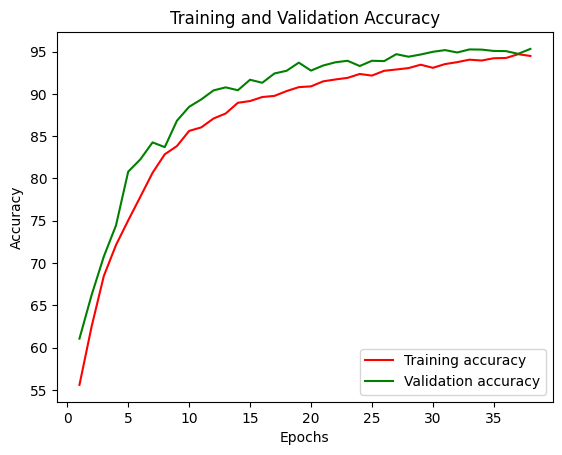

In [15]:
plt.plot(epochs_list, t_acc, color = 'r', label = 'Training accuracy')
plt.plot(epochs_list, v_acc, color = 'g', label = 'Validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Plotting the Training and Validation loss with respect to the number of epochs

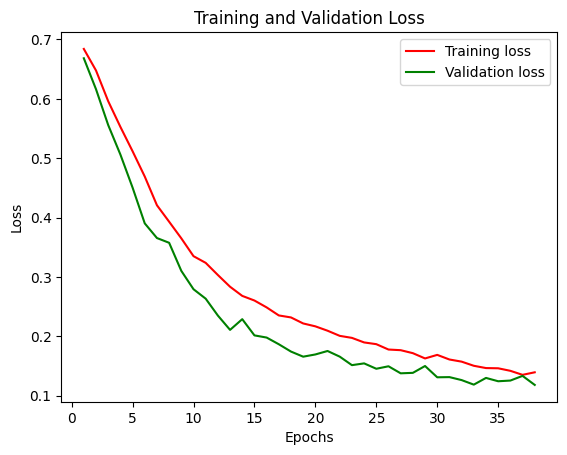

In [16]:
plt.plot(epochs_list, t_loss, color = 'r', label = 'Training loss')
plt.plot(epochs_list, v_loss, color = 'g', label = 'Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Testing the CNN Model

In [17]:
correct = 0
total = 0
model.load_state_dict(torch.load('cat_dog_classify.pth'))
model.eval()
for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f"Accuracy of the model is {(correct * 100)/total}")

Accuracy of the model is 94.26229508196721
